In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
# required since March 30, 2022
!pip install tornado==5.1
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 720 kB 33.2 MB/s 
     |████████████████████████████████| 61 kB 303 kB/s 
     |████████████████████████████████| 187 kB 61.4 MB/s 
     |████████████████████████████████| 1.2 MB 44.6 MB/s 
     |████████████████████████████████| 49 kB 7.6 MB/s 
     |████████████████████████████████| 56 kB 6.0 MB/s 
     |████████████████████████████████| 51 kB 382 kB/s 
     |████████████████████████████████| 561 kB 69.3 MB/s 
     |████████████████████████████████| 130 kB 70.4 MB/s 
     |████████████████████████████████| 428 kB 66.8 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires tornado~=5.1.0; python_version >= "3.0", but you have tornado 6.1 which is incompatible.
     |████████████████████████████████| 516 kB 22.8 MB/s 
  Created wheel for tornado: filename=tornado-5.1-cp37-cp37m-linux_x86_64.whl 

Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

In [3]:
#hide
# Mount the drive for our notebook
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [4]:
#hide
# Change directory to a specific folder for the data set
%cd /content/gdrive/MyDrive/data_sets/bluebook/

/content/gdrive/MyDrive/data_sets/bluebook


In [5]:
#hide
# Set the environment variable for where kaggle.json is located
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/data_sets/bluebook/'

In [ ]:
#hide
# Download the data set (only needs to be done once)
!kaggle competitions download -c bluebook-for-bulldozers

 68% 33.0M/48.4M [00:01<00:00, 20.6MB/s]
100% 48.4M/48.4M [00:01<00:00, 26.4MB/s]


In [ ]:
#hide
# Extract the data set
!7z x bluebook-for-bulldozers.zip


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 50792941 bytes (49 MiB)

Extracting archive: bluebook-for-bulldozers.zip
--
Path = bluebook-for-bulldozers.zip
Type = zip
Physical Size = 50792941

  0%      8% 1 - Machine_Appendix.csv                              17% 1 - Machine_Appendix.csv                              25% 3 - Train.7z                  33% 4 - Train.zip                   41% 6 - TrainAndValid.csv                           51% 6 - TrainAndValid.csv                          

# "Using auction data to predict sale price"
> "You mean you can predict my worth?"

- categories: [tabular]

To practice the theory from my [previous post](https://geon-youn.github.io/DunGeon/2022/03/23/Decision-Trees.html), I'm going to be training a random forest model on a data set used by a previous Kaggle competition: ["Blue Book for Bulldozers"](https://www.kaggle.com/c/bluebook-for-bulldozers). 

The contest took place 9 years ago and was sponsored by Fast Iron. Here is its description:

> The goal of the contest is to predict the sale price of a particular piece of heavy equiment at auction based on it's usage, equipment type, and configuaration.  The data is sourced from auction result postings and includes information on usage and equipment configurations.
> 
> Fast Iron is creating a "blue book for bull dozers," for customers to value what their heavy equipment fleet is worth at auction.



## Preprocessing the data set

First, we download the data set using the Kaggle API (to see how I did this, open the blog in Colab). Post download, we have these files:

In [ ]:
!ls

 bluebook-for-bulldozers.zip	    Test.csv	        Train.zip
'Data Dictionary.xlsx'		    tp.pkl	        Valid.7z
 kaggle.json			    Train.7z	        Valid.csv
 Machine_Appendix.csv		    TrainAndValid.7z    ValidSolution.csv
 median_benchmark.csv		    TrainAndValid.csv   Valid.zip
 random_forest_benchmark_test.csv   TrainAndValid.zip


Then, we can import the full data set into a Pandas `DataFrame` object:

In [ ]:
#
# When low_memory = True (default), Pandas only looks at a
# few rows to see what type the data in a specific column
# is. If we want to minimize errors and don't run into a
# low memory issue, we should set low_memory = False.
df = pd.read_csv('TrainAndValid.csv', low_memory = False)

This data set contains 53 different features:

In [ ]:
df.columns, len(df.columns)

(Index(['SalesID', 'SalePrice', 'MachineID', 'ModelID', 'datasource',
        'auctioneerID', 'YearMade', 'MachineHoursCurrentMeter', 'UsageBand',
        'saledate', 'fiModelDesc', 'fiBaseModel', 'fiSecondaryDesc',
        'fiModelSeries', 'fiModelDescriptor', 'ProductSize',
        'fiProductClassDesc', 'state', 'ProductGroup', 'ProductGroupDesc',
        'Drive_System', 'Enclosure', 'Forks', 'Pad_Type', 'Ride_Control',
        'Stick', 'Transmission', 'Turbocharged', 'Blade_Extension',
        'Blade_Width', 'Enclosure_Type', 'Engine_Horsepower', 'Hydraulics',
        'Pushblock', 'Ripper', 'Scarifier', 'Tip_Control', 'Tire_Size',
        'Coupler', 'Coupler_System', 'Grouser_Tracks', 'Hydraulics_Flow',
        'Track_Type', 'Undercarriage_Pad_Width', 'Stick_Length', 'Thumb',
        'Pattern_Changer', 'Grouser_Type', 'Backhoe_Mounting', 'Blade_Type',
        'Travel_Controls', 'Differential_Type', 'Steering_Controls'],
       dtype='object'), 53)

According to the "Data" tab in the [Kaggle competition page](https://www.kaggle.com/competitions/bluebook-for-bulldozers/data), the key features are in the data set are:

- `SalesID`: the uniue identifier of the sale.
- `MachineID`: the unique identifier of a machine.  A machine can be sold multiple times.
- `SalePrice`: what the machine sold for at auction (only provided in train.csv).
- `saledate`: the date of the sale.

After we read the data, we should handle the orderable categorical variables (called ordinal). We can do so by explicitly setting an order and telling Pandas that we want this column to be ordered by this new rule. The only feature for which this applies is the `ProductSize` column:

In [ ]:
df['ProductSize'].unique()

array([nan, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact'], dtype=object)

Currently, it's in a random order, but we can give it a specific order:

In [ ]:
sizes = 'Large','Large / Medium','Medium','Small','Mini','Compact'
df['ProductSize'] = df['ProductSize'].astype('category')
df['ProductSize'] = df['ProductSize'].cat.set_categories(sizes, ordered = True)

In [ ]:
df['ProductSize'].unique()

[NaN, 'Medium', 'Small', 'Large / Medium', 'Mini', 'Large', 'Compact']
Categories (6, object): ['Large' < 'Large / Medium' < 'Medium' < 'Small' < 'Mini' < 'Compact']

Next, we have to use the correct metric for the competition. For regression problems, we usually use RMSE, but the Kaggle competition usually states which metric to use. For this competition, we use RMSLE (root mean squared log error, which is the same as RMSE, but the predictions are log'd before RMSE). So, as a little preprocessing, we log the `SalePrice` column (and we can just use RMSE later and handle smaller prediction values while training):

In [ ]:
df['SalePrice'] = np.log(df['SalePrice'])

RMSLE is better to use than RMSE when you want to get a more accurate prediction. RMSLE is also larger for when you underestimate vs. when you overestimate. To learn more about RMSLE, read [this blog post](https://medium.com/analytics-vidhya/root-mean-square-log-error-rmse-vs-rmlse-935c6cc1802a).

We should also handle dates. Currently, the dates are just... the dates. 

In [ ]:
df['saledate'].head()

0    11/16/2006 0:00
1     3/26/2004 0:00
2     2/26/2004 0:00
3     5/19/2011 0:00
4     7/23/2009 0:00
Name: saledate, dtype: object

Dates are pretty special since some dates are more important than others. There's holidays, Fridays, Mondays, weekends, end of quarter, end of year, etc. So, we use fastai's `add_datepart` function that splits the date column into metadata columns. 

In [ ]:
df = add_datepart(df, 'saledate')

Evidently, fastai has generated many metadata columns and we now have 13 date related features:

In [ ]:
L([i for i in df if i.startswith('sale')]), len(df.columns)

((#13) ['saleYear','saleMonth','saleWeek','saleDay','saleDayofweek','saleDayofyear','saleIs_month_end','saleIs_month_start','saleIs_quarter_end','saleIs_quarter_start'...],
 65)

Next, we need to transform our data such that it has no strings or missing values. To do so, we use fastai's `TabularPandas` by passing in the `DataFrame`, `TabularProc`s, which features are categorical and which are continuous, what the dependent variable is, and how we're splitting the data. 

A `TabularProc` is a special kind of `Transform` that performs the transform when it's called instead of lazily as it's accessed, and returns the exact same object after modifying it in place. 

`Categorify` sets a number to each level in categorical columns, effectively making them continuous, with each assigned number having no meaning (the model learns the meanings on its own). If we defined an order beforehand like we did with `ProductSize`, then it takes that order instead of assigning a random ordering.

`FillMissing` takes missing values in continuous columns and assigns the average value of that continuous column. 

In [ ]:
procs = [Categorify, FillMissing]

We can use fastai's `cont_cat_split` that returns a tuple: `(continuous labels, categorical labels)`. When we define `dep_var = 'SalePrice'`, we tell `cont_cat_split` to ignore that column. The `1` is for the cardinality. Any column with cardinality greater than 1 will be assigned as continuous. 

In [ ]:
cont, cat = cont_cat_split(df, 1, dep_var = 'SalePrice')
L(cont), L(cat)

((#14) ['SalesID','MachineID','ModelID','datasource','auctioneerID','YearMade','MachineHoursCurrentMeter','saleYear','saleMonth','saleWeek'...],
 (#50) ['UsageBand','fiModelDesc','fiBaseModel','fiSecondaryDesc','fiModelSeries','fiModelDescriptor','ProductSize','fiProductClassDesc','state','ProductGroup'...])

To split our data as training and validation, we want to construct it so that our model can generalize to unseen data. Since this is a time series data set, we want our training set to occur before our validation set. So, we can split it according to time (`TrainAndValid.csv` goes up to April 2012, with `Test.csv` being six months after May 2012. We'll split our data such that the training is six months before April 2012: before November 2011):

In [ ]:
#
# Forms a copy of our current DataFrame, but has
# a True where the condition is true. The pipe
# '|' acts as 'union' for the sets. So, our
# condition is that it is before 2011 or November
cond = (df['saleYear'] < 2011) | (df['saleMonth'] < 11)

# The first element of the tuple produced by
# np.where contains the indices, i, where cond[i]
# was True
train_idx = np.where( cond)[0]

# Applying ~ to cond turns all True values to
# False and False to True
valid_idx = np.where(~cond)[0]

splits = (list(train_idx), list(valid_idx))

Now, we can put all of them inside of a `TabularPandas`:

In [ ]:
tp = TabularPandas(df, procs, cat, cont, y_names = 'SalePrice', splits = splits)

When we display the data, they don't seem changed:

In [ ]:
tp.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


But when we display them as items (what our model's going to see), all the categorical variables are changed to continuous variables:

In [ ]:
tp.items.head(3)

,SalesID,SalePrice,MachineID,ModelID,...,saleIs_year_start,saleElapsed,auctioneerID_na,MachineHoursCurrentMeter_na
0,1139246,11.097410,999089,3157,...,1,1.163635e+09,1,1
1,1139248,10.950807,117657,77,...,1,1.080259e+09,1,1
2,1139249,9.210340,434808,7009,...,1,1.077754e+09,1,1


And, like how we defined an order for `ProductSize`, the order is maintained:

In [ ]:
tp.classes['ProductSize']

['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact']

But for a feature whose order we didn't define, they're ordered alphabetically:

In [ ]:
tp.classes['state']

['#na#', 'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Unspecified', 'Utah', 'Vermont', 'Virginia', 'Washington', 'Washington DC', 'West Virginia', 'Wisconsin', 'Wyoming']

In [ ]:
#hide
save_pickle('tp.pkl', tp)

In [6]:
#hide
tp = load_pickle('tp.pkl')
tp.show(3)

,UsageBand,fiModelDesc,fiBaseModel,fiSecondaryDesc,fiModelSeries,fiModelDescriptor,ProductSize,fiProductClassDesc,state,ProductGroup,ProductGroupDesc,Drive_System,Enclosure,Forks,Pad_Type,Ride_Control,Stick,Transmission,Turbocharged,Blade_Extension,Blade_Width,Enclosure_Type,Engine_Horsepower,Hydraulics,Pushblock,Ripper,Scarifier,Tip_Control,Tire_Size,Coupler,Coupler_System,Grouser_Tracks,Hydraulics_Flow,Track_Type,Undercarriage_Pad_Width,Stick_Length,Thumb,Pattern_Changer,Grouser_Type,Backhoe_Mounting,Blade_Type,Travel_Controls,Differential_Type,Steering_Controls,saleIs_month_end,saleIs_month_start,saleIs_quarter_end,saleIs_quarter_start,saleIs_year_end,saleIs_year_start,auctioneerID_na,MachineHoursCurrentMeter_na,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,saleYear,saleMonth,saleWeek,saleDay,saleDayofweek,saleDayofyear,saleElapsed,SalePrice
0,Low,521D,521,D,#na#,#na#,#na#,Wheel Loader - 110.0 to 120.0 Horsepower,Alabama,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139246,999089,3157,121,3.0,2004,68.0,2006,11,46,16,3,320,1.163635e+09,11.097410
1,Low,950FII,950,F,II,#na#,Medium,Wheel Loader - 150.0 to 175.0 Horsepower,North Carolina,WL,Wheel Loader,#na#,EROPS w AC,None or Unspecified,#na#,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,2 Valve,#na#,#na#,#na#,#na#,23.5,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Standard,Conventional,False,False,False,False,False,False,False,False,1139248,117657,77,121,3.0,1996,4640.0,2004,3,13,26,4,86,1.080259e+09,10.950807
2,High,226,226,#na#,#na#,#na#,#na#,Skid Steer Loader - 1351.0 to 1601.0 Lb Operating Capacity,New York,SSL,Skid Steer Loaders,#na#,OROPS,None or Unspecified,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,Auxiliary,#na#,#na#,#na#,#na#,#na#,None or Unspecified,None or Unspecified,None or Unspecified,Standard,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,#na#,False,False,False,False,False,False,False,False,1139249,434808,7009,121,3.0,2001,2838.0,2004,2,9,26,3,57,1.077754e+09,9.210340


Now we processed our data and we can start training a random forest model!

## Modeling

First, we'll get the split data from our `TabularPandas` object:

In [ ]:
train_xs, train_y = tp.train.xs, tp.train.y
valid_xs, valid_y = tp.valid.xs, tp.valid.y

Then, we'll make a decision tree model as a baseline

In [ ]:
dt = DecisionTreeRegressor(min_samples_leaf = 25)
dt.fit(train_xs, train_y)

DecisionTreeRegressor(min_samples_leaf=25)

To see how well our model did, we can take the RMSE of our predictions since we took the log beforehand (so our models predict the log of the sale price). We'll define the functions so that we don't have to repeat it later:

In [7]:
def r_mse(preds, y):
    return round(math.sqrt(((preds - y)**2).mean()), 6)
    
def m_rmse(m, preds, y):
    return r_mse(m.predict(preds), y)

In [ ]:
m_rmse(dt, train_xs, train_y), m_rmse(dt, valid_xs, valid_y)

(0.211429, 0.266451)

So, we should be trying to train a model that has a better RMSE than 0.266.

In [ ]:
#hide
pd.DataFrame({'cols': train_xs.columns, 'imp': dt.feature_importances_}).sort_values('imp', ascending = False)

,cols,imp
30,Coupler_System,0.223597
57,YearMade,0.186213
6,ProductSize,0.136194
7,fiProductClassDesc,0.119341
54,ModelID,0.095098
...,...,...
47,saleIs_quarter_start,0.000000
19,Blade_Extension,0.000000
18,Turbocharged,0.000000
46,saleIs_quarter_end,0.000000


We'll train our random forest model as an ensemble of 40 decision trees:

In [8]:
def rf(xs, y, n_estimators = 40, max_samples = 200_000, 
       max_features = 0.5, min_samples_leaf = 5, **kwargs):
    return RandomForestRegressor(
        n_jobs       = -1,                   # use all CPU cores
        n_estimators = n_estimators,         # number of decision trees
        max_samples  = max_samples,          # max number of rows to get
        max_features = max_features,         # how many columns to get (%)
        min_samples_leaf = min_samples_leaf, # leaf nodes must have at least this many (to prevent overfitting)
        oob_score    = True                  # track out-of-box error score
    ).fit(xs, y)

In [ ]:
m = rf(train_xs, train_y)

In [ ]:
m_rmse(m, train_xs, train_y), m_rmse(m, valid_xs, valid_y)

(0.171233, 0.23292)

And, our out-of-bag error is:

In [ ]:
r_mse(m.oob_prediction_, train_y)

0.210877

Since it's smaller than our validation error, our model shouldn't be overfitting and is instead having other problems.

In [ ]:
#hide
save_pickle('m.pkl', m)

In [ ]:
#hide
m = load_pickle('m.pkl')

## Interpretation

First, we'll look at the confidence of each tree:

In [ ]:
preds = np.stack([t.predict(valid_xs.values) for t in m.estimators_])
preds.shape # we should have 40 trees

(40, 5754)

In [ ]:
preds_std = preds.std(0)
preds_std.sort()
preds_std

array([0.04779576, 0.05120998, 0.0513565 , ..., 0.5755972 , 0.57621563, 0.57734788])

The standard deviations of the predictions for each auction ranges from 0.00478 to 0.57735 since the trees for some auctions agree (low standard deviation), while other times they disagree (high standard deviation). In production, you could warn the user to be more wary of the prediction if the standard deviation is above a certain threshold.

To see which features were the most important, we can use the `.feature_imporances_` attribute of our `RandomForestRegressor` model to get each columns' feature importance score. We can pair it up with the column names in a `DataFrame` and sort it to see which features were the most important.

In [9]:
def feature_importance(df, m):
    return pd.DataFrame({'Feature': df.columns, 'Importance': m.feature_importances_}).sort_values('Importance', ascending = False)

In [ ]:
fi = feature_importance(train_xs, m)

In [ ]:
fi[:10]

,Feature,Importance
57,YearMade,0.184860
6,ProductSize,0.114785
30,Coupler_System,0.114240
7,fiProductClassDesc,0.078662
54,ModelID,0.058189
65,saleElapsed,0.050378
3,fiSecondaryDesc,0.038825
12,Enclosure,0.038811
32,Hydraulics_Flow,0.036170
1,fiModelDesc,0.032337


We'll try removing the unimportant features and see if it affects the model's performance. First, we set a threshold (0.005) and only take the columns whose importance is greater than that threshold:

In [ ]:
imp = fi[fi.Importance > 0.005].Feature
len(imp)

21

Then, we make new training and validation sets:

In [ ]:
train_xs_imp = train_xs[imp]
valid_xs_imp = valid_xs[imp]
train_xs_imp

,YearMade,ProductSize,Coupler_System,fiProductClassDesc,...,Drive_System,MachineID,Hydraulics,Tire_Size
0,2004,0,0,59,...,0,999089,1,17
1,1996,3,0,62,...,0,117657,1,12
2,2001,0,1,39,...,0,434808,4,0
3,2001,4,0,8,...,0,1026470,1,0
4,2007,0,1,40,...,0,1057373,4,0
...,...,...,...,...,...,...,...,...,...
412693,2005,5,0,13,...,0,1919201,12,0
412694,2005,5,0,17,...,0,1882122,4,0
412695,2005,5,0,13,...,0,1944213,4,0
412696,2006,5,0,13,...,0,1794518,4,0


Finally, we train a new model using the new training set:

In [ ]:
m_imp = rf(train_xs_imp, train_y)

In [ ]:
m_rmse(m_imp, train_xs_imp, train_y), m_rmse(m_imp, valid_xs_imp, valid_y)

(0.181282, 0.233111)

Although our training metric become a bit worse, our validation metric isn't far off, so we can train future models using this new training set since we can effectively remove 2/3 of the "unncessary" columns. 

In [ ]:
#hide
save_pickle("xs_imp.pkl", train_xs_imp)
save_pickle("valid_xs_imp.pkl", valid_xs_imp)

In [ ]:
#hide
train_xs_imp = load_pickle("xs_imp.pkl")
valid_xs_imp = load_pickle("valid_xs_imp.pkl")
train_y, valid_y = tp.train.y, tp.valid.y

Next, we'll remove the redundant columns. We'll use `cluster_columns` which determines feature similarity through rank correlation. 

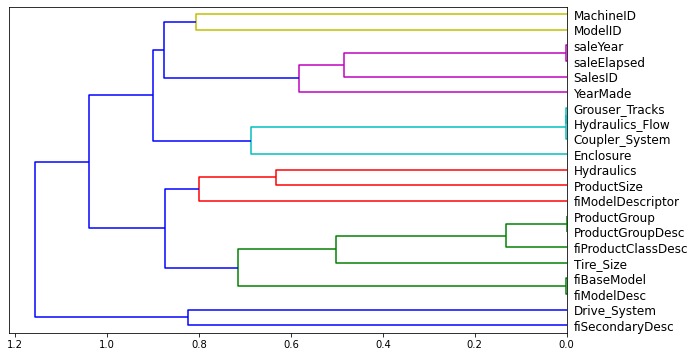

In [ ]:
cluster_columns(train_xs_imp)

We'll see how removing each redundant feature affects the model's capability by defining a function that trains a quick random forest model and returns its out-of-box error:

In [10]:
def get_oob(df):
    m = RandomForestRegressor(
        n_estimators = 40, 
        min_samples_leaf = 15, # higher to have a shorter depth tree
        max_samples = 50_000,
        max_features = 0.5,
        n_jobs = -1,
        oob_score = True).fit(df, train_y)
    return m.oob_score_

The `oob_score_`, unlike `oob_prediction_`, returns $R^2$, so a perfect model has a score of 1.0 while a random models has 0.0. As a baseline, we'll first find the `oob_score_` of our current training set:

In [ ]:
get_oob(train_xs_imp)

0.8771422789129072

Then, we'll try removing each possibly redundant feature one by one:

In [ ]:
{c: get_oob(train_xs_imp.drop(labels = c, axis = 'columns'))
            for c in ('saleYear', 'saleElapsed', 'Grouser_Tracks', 
                      'Hydraulics_Flow', 'Coupler_System', 
                      'ProductGroup', 'ProductGroupDesc',
                      'fiBaseModel', 'fiModelDesc')}

{'Coupler_System': 0.8777286429358461,
 'Grouser_Tracks': 0.8781106723829636,
 'Hydraulics_Flow': 0.8778805337963219,
 'ProductGroup': 0.87719310108094,
 'ProductGroupDesc': 0.877706764282738,
 'fiBaseModel': 0.8755285591209638,
 'fiModelDesc': 0.8760491649430575,
 'saleElapsed': 0.8726949857217733,
 'saleYear': 0.8762485106840037}

Since the out-of-box score didn't change much, we'll try leaving just one of them in each group:

In [ ]:
to_drop = ['saleYear', 'Grouser_Tracks', 'Hydraulics_Flow', 'ProductGroup', 'fiBaseModel']
get_oob(train_xs_imp.drop(to_drop, axis = 1))

0.8754873568883906

The score ultimately only goes down by 0.002 from our baseline, so we'll drop these labels from our training and validation set.

In [ ]:
train_xs_fin = train_xs_imp.drop(to_drop, axis = 1)
valid_xs_fin = valid_xs_imp.drop(to_drop, axis = 1)

While we're at it, we'll also adjust the years so that the minimum year isn't at 1000 but instead at 1950

In [ ]:
train_xs_fin.loc[train_xs_fin.YearMade < 1950, 'YearMade'] = 1950
valid_xs_fin.loc[valid_xs_fin.YearMade < 1950, 'YearMade'] = 1950

In [ ]:
#hide
save_pickle('train_xs_fin.pkl', train_xs_fin)
save_pickle('valid_xs_fin.pkl', valid_xs_fin)

In [ ]:
#hide
train_xs_fin = load_pickle("train_xs_fin.pkl")
valid_xs_fin = load_pickle("valid_xs_fin.pkl")
train_y, valid_y = tp.train.y, tp.valid.y

Now, we'll check that our RMSE didn't decrease significantly:

In [ ]:
m = rf(train_xs_fin, train_y)
m_rmse(m, train_xs_fin, train_y), m_rmse(m, valid_xs_fin, valid_y)

(0.182645, 0.234452)

The validation RMSE didn't decrease much and now we only have 16 columns instead of 66. 

In [ ]:
len(train_xs_fin.columns)

16

In [ ]:
#hide
fi = feature_importance(train_xs_fin, m)
fi

,Feature,Importance
0,YearMade,0.174341
2,Coupler_System,0.145615
1,ProductSize,0.120675
3,fiProductClassDesc,0.075403
5,saleElapsed,0.074216
7,Enclosure,0.064746
4,ModelID,0.059728
6,fiSecondaryDesc,0.058188
10,ProductGroupDesc,0.051185
8,fiModelDesc,0.047211


With most of the unnecessary features removed, we can revisit feature importance and look at the partial dependence plots of some of the most important features and how our predictions depend on the features:

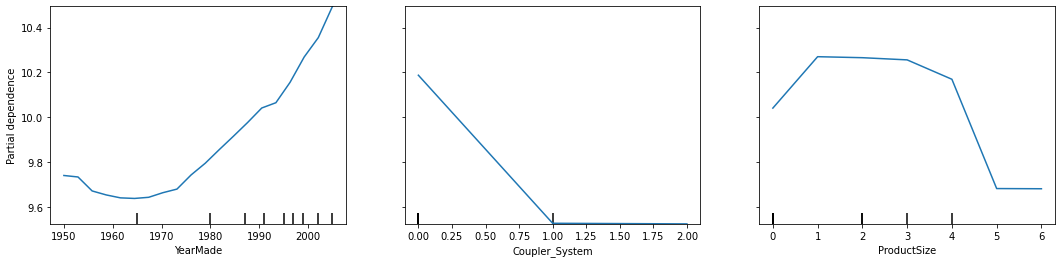

In [ ]:
from sklearn.inspection import PartialDependenceDisplay

fig, ax = plt.subplots(figsize = (18, 4))
PartialDependenceDisplay.from_estimator(m, train_xs_fin, 
    ['YearMade', 'Coupler_System', 'ProductSize'], grid_resolution = 20, ax = ax)

From these plots, it appears that price has an exponential relationship with year, which makes sense (since products tend to depreciate exponentially over time). But for the other two, the missing data seems to be quite important:

In [ ]:
tp.classes['Coupler_System'], tp.classes['ProductSize']

(['#na#', 'None or Unspecified', 'Yes'],
 ['#na#', 'Large', 'Large / Medium', 'Medium', 'Small', 'Mini', 'Compact'])

Coupler systems, although it's the second most important feature, makes its most important decision on whether it was filled out or not... and with product sizes, although it makes sense that the price decreases as the size decreases, no size mentioned also plays a significant role. 

If we were the ones who created the data set, it would be interesting to see why that might be the case. Maybe only data entered after a certain date contained these values, or maybe these columns aren't as important. 

Next, we can look at how the features influence the prediction. To do so, we can use the `treeinterpreter` library to see how the features influence the prediction, and then use the `waterfallcharts` library to draw it.

In [ ]:
#hide
import warnings
warnings.simplefilter('ignore', FutureWarning)

from treeinterpreter import treeinterpreter
from waterfall_chart import plot as waterfall

For the `treeinterpreter`, we pass the model and the rows of data for which we want predictions. Then, it returns a tuple of three items:
- `prediction` is the predicted value for the dependent variable.
- `bias` is the mean of the dependent variable. 
- `contributions` is a list of contributions made by each feature.

So, `prediction = bias - contributions.sum()`. And, we'll plot the contributions using a waterfall chart. 

In [ ]:
nrows = 1
row = 0
prediction, bias, contributions = treeinterpreter.predict(m, valid_xs_fin[:nrows].values)
prediction[row], bias[row], contributions[row].sum()

(array([10.64886316]), 10.104243648162724, 0.5446195099995459)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

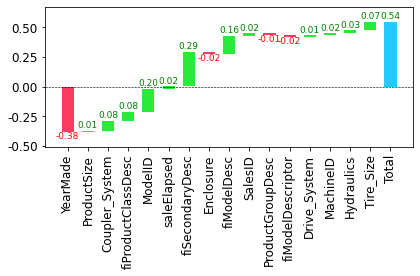

In [ ]:
waterfall(valid_xs_fin.columns, contributions[row], 
          rotation_value = 90, formatting = '{:,.2f}', net_label = 'Total')

So, it seems that `YearMade`, `ModelID`, `fiSecondaryDesc`, and `fiModelDesc` were the most important features for this row's prediction. 

But, it's a bit weird that `ModelID` is an important feature. What would happen when we have a new system for `ModelID` in the future? So, we should try to find out-of-domain data by combining our training and validation sets and train a model to predict whether a row is from the training or validation set.

In [ ]:
df_domain = pd.concat([train_xs_fin, valid_xs_fin])
is_valid  = np.array([0] * len(train_xs_fin) + [1] * len(valid_xs_fin))
m         = rf(df_domain, is_valid)

In [ ]:
feature_importance(df_domain, m)[:6]

,Feature,Importance
5,saleElapsed,0.919558
9,SalesID,0.061309
13,MachineID,0.014026
0,YearMade,0.000824
4,ModelID,0.000767
11,fiModelDescriptor,0.000733


So, the main things that appear to change from the training and validation set are `saleElapsed`, `SalesID`,and `MachineID`. Like before, let's try removing each of them and see how our model changes.

In [ ]:
m = rf(train_xs_fin, train_y)
m_rmse(m, valid_xs_fin, valid_y)

0.23369

In [ ]:
{c: m_rmse(rf(train_xs_fin.drop(c, axis = 1), train_y), 
           valid_xs_fin.drop(c, axis = 1),
           valid_y)
 for c in ['saleElapsed', 'SalesID', 'MachineID', 'YearMade', 'ModelID']}

{'MachineID': 0.233734,
 'ModelID': 0.238536,
 'SalesID': 0.231391,
 'YearMade': 0.268748,
 'saleElapsed': 0.237849}

So, it appears that we can remove `MachineID` and `SalesID` without worry (the model actually improved when we removed `SalesID`).

In [ ]:
to_drop = ['MachineID', 'SalesID']
xs_new       = train_xs_fin.drop(to_drop, axis = 1)
valid_xs_new = valid_xs_fin.drop(to_drop, axis = 1)

And we'll double check our model's RMSE didn't go up significantly:

In [13]:
m = rf(xs_new, train_y)
m_rmse(m, valid_xs_new, valid_y)

0.230939

Not only did it not go up, it actually went down. So, removing `MachineID` and `SalesID`, which probably correlated with `YearMade` and `saleElapsed`, made the model better. 

In [ ]:
#hide
save_pickle('xs_new.pkl', xs_new)
save_pickle('valid_xs_new.pkl', valid_xs_new)

In [11]:
#hide
xs_new       = load_pickle('xs_new.pkl') 
valid_xs_new = load_pickle('valid_xs_new.pkl')
train_y, valid_y = tp.train.y, tp.valid.y

For the next blog, I'll train a deep learning model using the information gained through training and analyzing a random forest model. Then, I'll use the embeddings learned by the neural network to retrain a random forest model and try to beat the #1 gold-medal-level model on the leaderboards. 